In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
from torchvision.utils import save_image
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CA_model import *
from Perturbation_CA import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

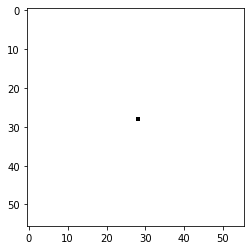

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

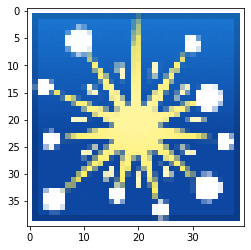

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883), tensor(0))

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [7]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("firework_growing.pt")

Successfully loaded model!


In [8]:
new_CA = CAModel().to(device)
new_CA.load("new_CA_with_average_between_old_and_new/new_CA.pt")

Successfully loaded model!


In [9]:
model = PerturbationCA(old_CA, new_CA, None)

In [49]:
# Train the model
torch.backends.cudnn.benchmark = True

for param in model.old_CA.parameters():
   param.requires_grad = False

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=2e-3)
criterion = loss_fn2(pad(target, TARGET_PADDING), order=2, l=1.)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=150, scheduler=scheduler, evolution_iters=55, batch_size=2, kind="regenerating", square_side=15)
# torch.nn.utils.clip_grad_norm_(model.new_CA.parameters(), 1.)

epoch: 150
avg loss: 0.005960089693871851


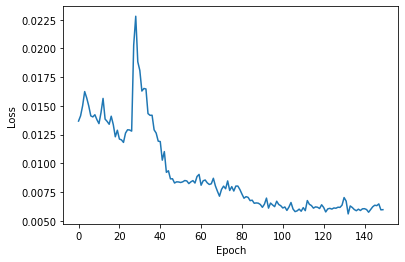

In [68]:
pl.plot(model.losses[-150:])
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.savefig(fname="pertutbation_regeneration_l=1_losses.png", dpi=200)

In [13]:
torch.max(model.new_CA(x))

NameError: name 'x' is not defined

In [66]:
norms_old[-1]/norms_new[-1]

1.6108144811684284

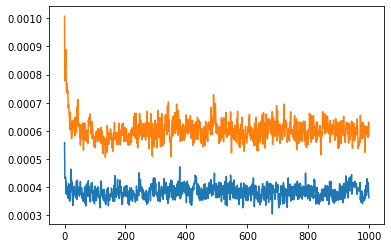

In [60]:
norms_old = []
norms_new = []
with torch.no_grad():
    x = pool.sample(1)[0].cuda()
    for i in range(1000):
        pre_life_mask = model.new_CA.get_living_mask(x)

        dx_new = model.new_CA.compute_dx(x)
        dx_old = model.old_CA.compute_dx(x)

        post_life_mask = model.new_CA.get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        norm = torch.mean((dx_new*life_mask)**2)
        norms_new.append(norm.detach().cpu().item())
        norm = torch.mean((dx_old*life_mask)**2)
        norms_old.append(norm.detach().cpu().item())
        x = model.forward(x)

pl.plot(norms_new)
pl.plot(norms_old)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


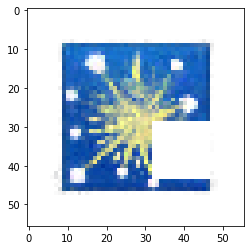

In [57]:
imshow(pool.sample(1)[0][0])

In [23]:
torch.mean(model.new_cells.detach().cpu()**2)

tensor(0.0002)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


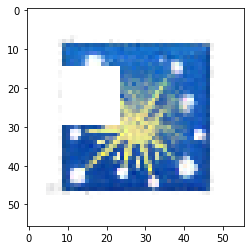

In [61]:
imshow(model.evolve(pool[1:2][0].cuda(), 0)[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


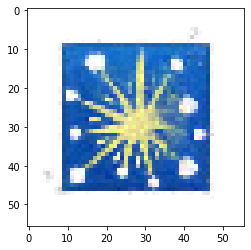

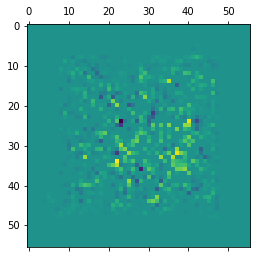

In [65]:
imshow(model.evolve(pool[1:2][0].cuda(), 1000)[0].cpu())
pl.matshow(model.new_cells.detach().cpu()[0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


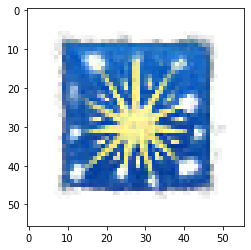

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

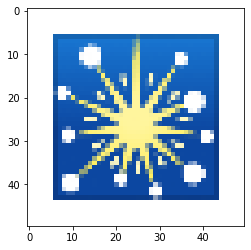

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))